# Cybersecurity Incident & Threat Detection Risk Analysis

**Author**: Fatima Abdullah 
**Purpose**: Comprehensive analysis of security incidents and login activity for risk assessment and threat detection

---

In [4]:
# Core data analysis libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo

# Statistical analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

# Machine Learning for anomaly detection
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Date and time handling
import datetime as dt
from datetime import datetime, timedelta

# System and utilities
import os
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pyo.init_notebook_mode(connected=True)

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)


<a id="data-loading"></a>
## 1. Data Loading & Initial Exploration

Load the cybersecurity incident and login datasets, perform initial validation, and understand the data structure.


In [5]:
# Define file paths
INCIDENTS_PATH = '/kaggle/input/incidents-and-logins/incidents.csv'
LOGINS_PATH = '/kaggle/input/incidents-and-logins/logins.csv'

# Load incidents data
try:
    incidents_df = pd.read_csv(INCIDENTS_PATH)
except FileNotFoundError:
    print(f"Error: File not found")
    raise

# Load logins data
try:
    logins_df = pd.read_csv(LOGINS_PATH)
except FileNotFoundError:
    print(f"Error: File not found")
    raise

print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)

print(f"Incidents Dataset Shape: {incidents_df.shape}")
print(f"Logins Dataset Shape: {logins_df.shape}")
print(f"Total Records: {len(incidents_df) + len(logins_df):,}")



DATASET OVERVIEW
Incidents Dataset Shape: (5000, 8)
Logins Dataset Shape: (3000, 5)
Total Records: 8,000


In [6]:
# Display basic information about the datasets
incidents_df.info()
logins_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   event_id            5000 non-null   int64 
 1   timestamp           5000 non-null   object
 2   event_type          5000 non-null   object
 3   severity            5000 non-null   object
 4   source_ip           5000 non-null   object
 5   destination_device  5000 non-null   object
 6   status              5000 non-null   object
 7   location            5000 non-null   object
dtypes: int64(1), object(7)
memory usage: 312.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_id    3000 non-null   int64 
 1   user_id     3000 non-null   object
 2   login_time  3000 non-null   object
 3   success     3000 non-null   object
 4   ip_address 

In [7]:
# Display sample data
display(incidents_df.head())
display(logins_df.head())


,event_id,timestamp,event_type,severity,source_ip,destination_device,status,location
0,1,2025-01-23 11:34:00,Failed Login,Low,251.96.130.36,Device-37,Blocked,Egypt
1,2,2025-02-18 15:12:00,Phishing Attempt,Low,146.84.59.79,Device-43,Successful,Egypt
2,3,2025-02-09 10:03:00,Failed Login,Critical,186.190.161.111,Device-38,Successful,Germany
3,4,2025-02-18 11:13:00,Malware,Low,232.176.159.46,Device-34,Successful,USA
4,5,2025-01-29 03:12:00,Brute Force,Medium,222.138.38.205,Device-20,Failed,UAE


,login_id,user_id,login_time,success,ip_address
0,1,user82,2025-02-15 13:45:00,Yes,67.86.56.10
1,2,user59,2025-01-20 11:14:00,No,119.40.104.221
2,3,user23,2025-01-28 11:56:00,No,113.108.66.64
3,4,user92,2025-02-03 02:20:00,Yes,63.253.181.19
4,5,user68,2025-01-23 15:37:00,Yes,176.160.118.3


In [8]:
# Basic statistical summary

display(incidents_df.describe())
display(logins_df.describe())


,event_id
count,5000.000000
mean,2500.500000
std,1443.520003
min,1.000000
25%,1250.750000
50%,2500.500000
75%,3750.250000
max,5000.000000


,login_id
count,3000.000000
mean,1500.500000
std,866.169729
min,1.000000
25%,750.750000
50%,1500.500000
75%,2250.250000
max,3000.000000


<a id="data-quality"></a>
## 2. Data Quality Assessment & Cleaning

Assess data quality, handle missing values, validate data types, and prepare data for analysis.

In [9]:
def assess_data_quality(df, name):
    """Comprehensive data quality assessment function"""
    print(f"\nDATA QUALITY ASSESSMENT: {name.upper()}")
    print("="*60)
    
    # Check for missing values
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    
    print("\nMISSING VALUES:")
    for col, count in missing_data.items():
        if count > 0:
            print(f"  {col}: {count:,} ({missing_percent[col]:.2f}%)")
    
    if missing_data.sum() == 0:
        print("No missing values found")
    
    # Check for duplicates
    duplicates = df.duplicated().sum()
    print(f"\nDUPLICATE RECORDS: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")
    
    # Data type validation
    print("\nDATA TYPES:")
    for col, dtype in df.dtypes.items():
        print(f"  {col}: {dtype}")
    
    # Unique values in categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    print("\nCATEGORICAL COLUMNS UNIQUE VALUES:")
    for col in categorical_cols:
        unique_vals = df[col].nunique()
        print(f"  {col}: {unique_vals} unique values")
        if unique_vals <= 10:
            print(f"    Values: {sorted(df[col].dropna().unique())}")
    
    return missing_data, duplicates

# Assess data quality for both datasets
incidents_missing, incidents_dupes = assess_data_quality(incidents_df, "Incidents")
logins_missing, logins_dupes = assess_data_quality(logins_df, "Logins")



DATA QUALITY ASSESSMENT: INCIDENTS

MISSING VALUES:
No missing values found

DUPLICATE RECORDS: 0 (0.00%)

DATA TYPES:
  event_id: int64
  timestamp: object
  event_type: object
  severity: object
  source_ip: object
  destination_device: object
  status: object
  location: object

CATEGORICAL COLUMNS UNIQUE VALUES:
  timestamp: 4850 unique values
  event_type: 6 unique values
    Values: ['Brute Force', 'Failed Login', 'Firewall Block', 'Malware', 'Phishing Attempt', 'Port Scan']
  severity: 4 unique values
    Values: ['Critical', 'High', 'Low', 'Medium']
  source_ip: 5000 unique values
  destination_device: 50 unique values
  status: 4 unique values
    Values: ['Allowed', 'Blocked', 'Failed', 'Successful']
  location: 6 unique values
    Values: ['Egypt', 'Germany', 'KSA', 'UAE', 'USA', 'Unknown']

DATA QUALITY ASSESSMENT: LOGINS

MISSING VALUES:
No missing values found

DUPLICATE RECORDS: 0 (0.00%)

DATA TYPES:
  login_id: int64
  user_id: object
  login_time: object
  success: o

In [10]:
# Data type conversions and cleaning
def clean_and_prepare_data(incidents_df, logins_df):
    """Clean and prepare data for analysis"""
    print("\nDATA CLEANING & PREPARATION")
    print("="*60)
    
    # Create copies to avoid modifying original data
    incidents_clean = incidents_df.copy()
    logins_clean = logins_df.copy()
    
    # Convert timestamps to datetime
    incidents_clean['timestamp'] = pd.to_datetime(incidents_clean['timestamp'], errors='coerce')
    logins_clean['login_time'] = pd.to_datetime(logins_clean['login_time'], errors='coerce')
    
    # Handle any conversion errors
    timestamp_errors = incidents_clean['timestamp'].isnull().sum()
    login_time_errors = logins_clean['login_time'].isnull().sum()
    
    if timestamp_errors > 0:
        print(f"{timestamp_errors} timestamp conversion errors in incidents")
    if login_time_errors > 0:
        print(f"{login_time_errors} timestamp conversion errors in logins")
    
    # Clean severity values (ensure consistent casing)
    if 'severity' in incidents_clean.columns:
        incidents_clean['severity'] = incidents_clean['severity'].str.title()
        
    # Clean location data
    if 'location' in incidents_clean.columns:
        incidents_clean['location'] = incidents_clean['location'].str.strip()
    
    # Remove duplicates if any
    original_incidents = len(incidents_clean)
    original_logins = len(logins_clean)
    
    incidents_clean = incidents_clean.drop_duplicates()
    logins_clean = logins_clean.drop_duplicates()
    
    removed_incidents = original_incidents - len(incidents_clean)
    removed_logins = original_logins - len(logins_clean)
    
    if removed_incidents > 0:
        print(f"Removed {removed_incidents} duplicate incident records")
    if removed_logins > 0:
        print(f"Removed {removed_logins} duplicate login records")
    
    # Add derived columns for analysis
    print("Adding derived columns for analysis...")
    
    # Date components for incidents
    incidents_clean['date'] = incidents_clean['timestamp'].dt.date
    incidents_clean['hour'] = incidents_clean['timestamp'].dt.hour
    incidents_clean['day_of_week'] = incidents_clean['timestamp'].dt.day_name()
    incidents_clean['month'] = incidents_clean['timestamp'].dt.month_name()
    incidents_clean['year'] = incidents_clean['timestamp'].dt.year
    
    # Date components for logins
    logins_clean['date'] = logins_clean['login_time'].dt.date
    logins_clean['hour'] = logins_clean['login_time'].dt.hour
    logins_clean['day_of_week'] = logins_clean['login_time'].dt.day_name()
    logins_clean['month'] = logins_clean['login_time'].dt.month_name()
    logins_clean['year'] = logins_clean['login_time'].dt.year
    
    # Severity score for quantitative analysis
    severity_mapping = {'Low': 1, 'Medium': 2, 'High': 3, 'Critical': 4}
    incidents_clean['severity_score'] = incidents_clean['severity'].map(severity_mapping)
    
    print("Derived columns added")
    print(f"Final incidents dataset: {len(incidents_clean):,} records")
    print(f"Final logins dataset: {len(logins_clean):,} records")
    
    return incidents_clean, logins_clean

# Clean and prepare the data
incidents_clean, logins_clean = clean_and_prepare_data(incidents_df, logins_df)



DATA CLEANING & PREPARATION
Adding derived columns for analysis...
Derived columns added
Final incidents dataset: 5,000 records
Final logins dataset: 3,000 records


In [11]:
# Display cleaned data samples
display(incidents_clean.head())
display(logins_clean.head())


,event_id,timestamp,event_type,severity,source_ip,destination_device,status,location,date,hour,day_of_week,month,year,severity_score
0,1,2025-01-23 11:34:00,Failed Login,Low,251.96.130.36,Device-37,Blocked,Egypt,2025-01-23,11,Thursday,January,2025,1
1,2,2025-02-18 15:12:00,Phishing Attempt,Low,146.84.59.79,Device-43,Successful,Egypt,2025-02-18,15,Tuesday,February,2025,1
2,3,2025-02-09 10:03:00,Failed Login,Critical,186.190.161.111,Device-38,Successful,Germany,2025-02-09,10,Sunday,February,2025,4
3,4,2025-02-18 11:13:00,Malware,Low,232.176.159.46,Device-34,Successful,USA,2025-02-18,11,Tuesday,February,2025,1
4,5,2025-01-29 03:12:00,Brute Force,Medium,222.138.38.205,Device-20,Failed,UAE,2025-01-29,3,Wednesday,January,2025,2


,login_id,user_id,login_time,success,ip_address,date,hour,day_of_week,month,year
0,1,user82,2025-02-15 13:45:00,Yes,67.86.56.10,2025-02-15,13,Saturday,February,2025
1,2,user59,2025-01-20 11:14:00,No,119.40.104.221,2025-01-20,11,Monday,January,2025
2,3,user23,2025-01-28 11:56:00,No,113.108.66.64,2025-01-28,11,Tuesday,January,2025
3,4,user92,2025-02-03 02:20:00,Yes,63.253.181.19,2025-02-03,2,Monday,February,2025
4,5,user68,2025-01-23 15:37:00,Yes,176.160.118.3,2025-01-23,15,Thursday,January,2025


<a id="eda"></a>
## 3. Exploratory Data Analysis (EDA)

Performing comprehensive exploratory data analysis to understand patterns, distributions, and relationships in the data.

OVERVIEW DASHBOARD


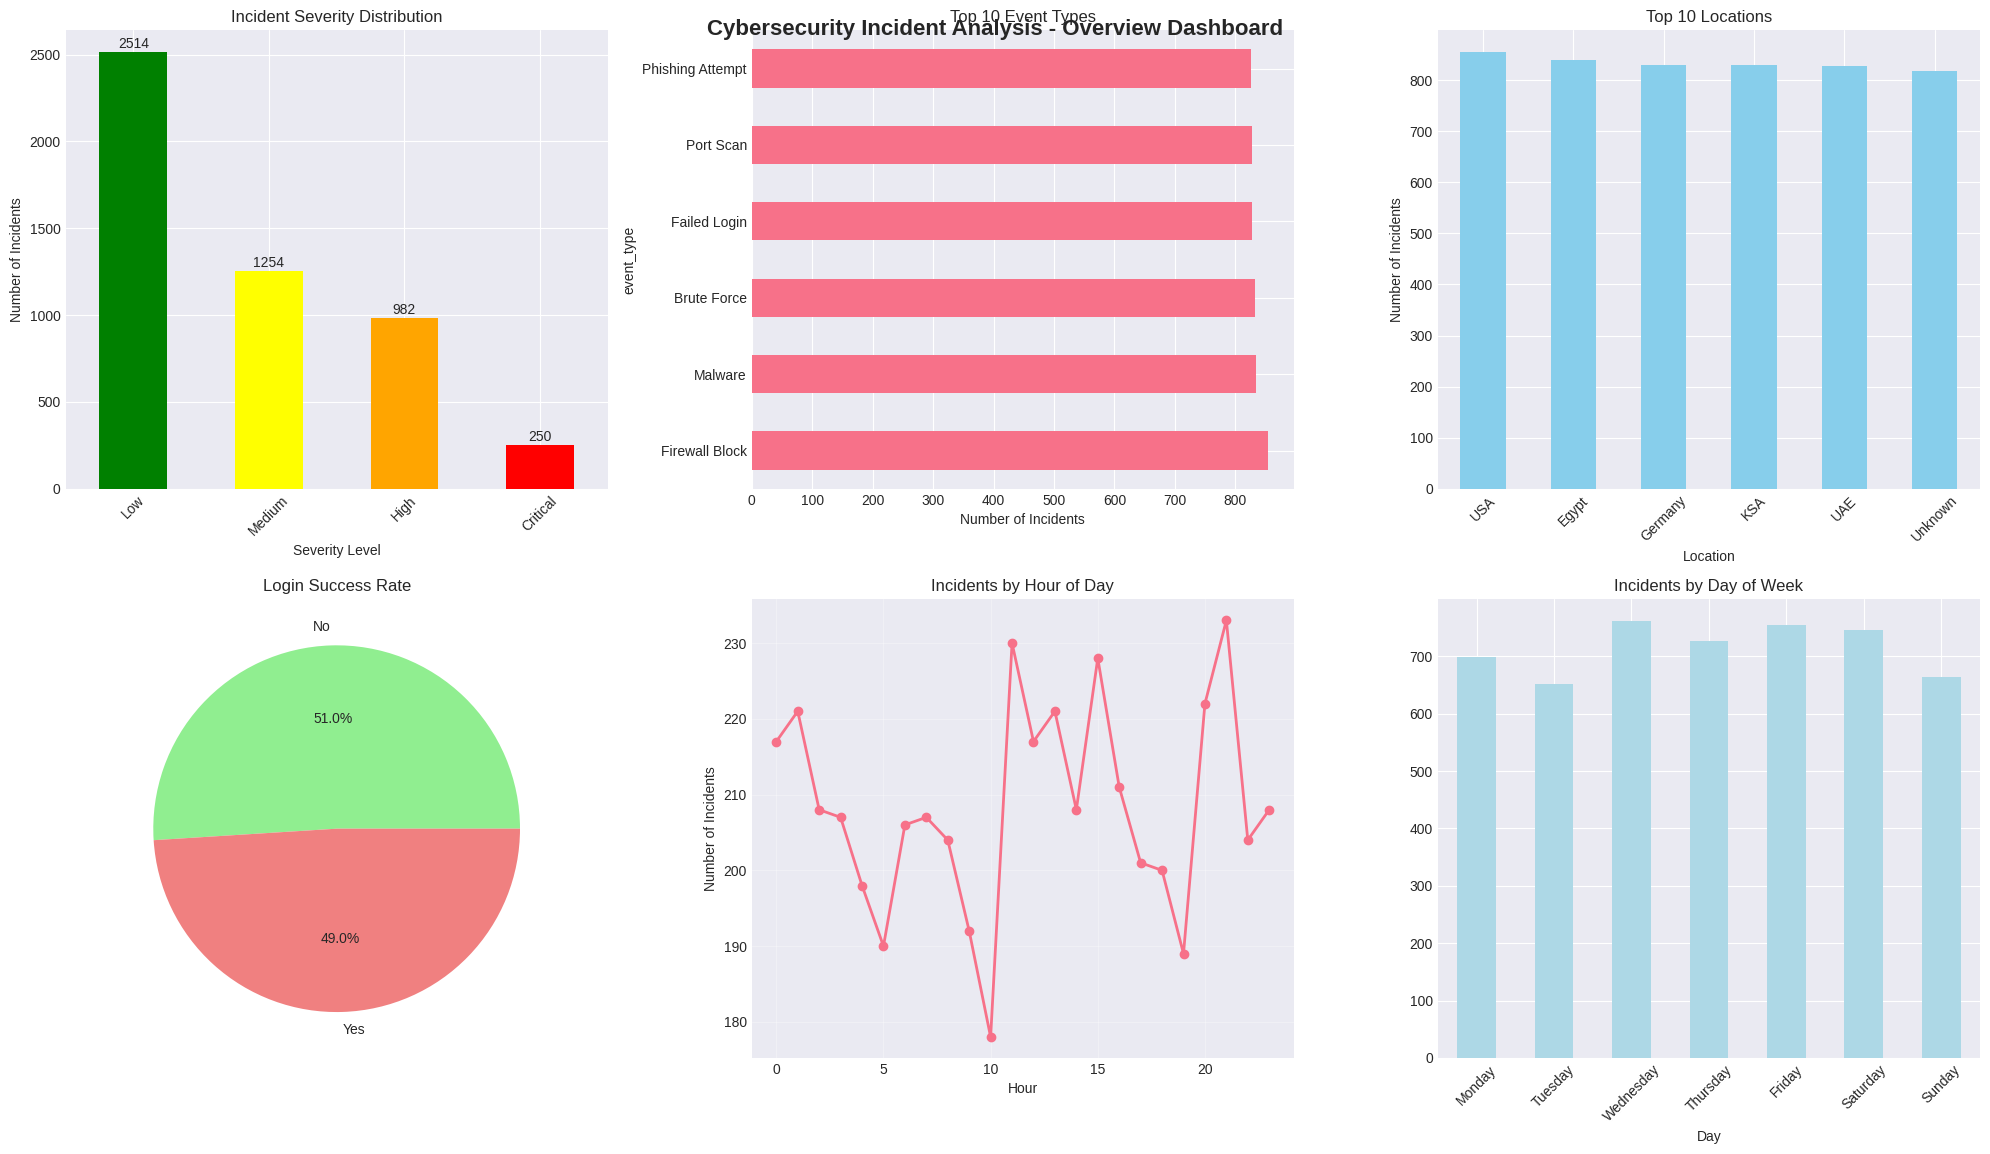

In [12]:
# Set up the plotting environment
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

def create_overview_dashboard(incidents_clean, logins_clean):
    """Create a comprehensive overview dashboard"""
    print("OVERVIEW DASHBOARD")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Cybersecurity Incident Analysis - Overview Dashboard', 
                 fontsize=16, fontweight='bold', y=0.95)
    
    # 1. Severity Distribution
    severity_counts = incidents_clean['severity'].value_counts()
    colors = ['green', 'yellow', 'orange', 'red']
    severity_counts.plot(kind='bar', ax=axes[0,0], color=colors)
    axes[0,0].set_title('Incident Severity Distribution')
    axes[0,0].set_xlabel('Severity Level')
    axes[0,0].set_ylabel('Number of Incidents')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, v in enumerate(severity_counts):
        axes[0,0].text(i, v + max(severity_counts)*0.01, str(v), ha='center')
    
    # 2. Event Type Distribution
    event_counts = incidents_clean['event_type'].value_counts().head(10)
    event_counts.plot(kind='barh', ax=axes[0,1])
    axes[0,1].set_title('Top 10 Event Types')
    axes[0,1].set_xlabel('Number of Incidents')
    
    # 3. Geographic Distribution
    location_counts = incidents_clean['location'].value_counts().head(10)
    location_counts.plot(kind='bar', ax=axes[0,2], color='skyblue')
    axes[0,2].set_title('Top 10 Locations')
    axes[0,2].set_xlabel('Location')
    axes[0,2].set_ylabel('Number of Incidents')
    axes[0,2].tick_params(axis='x', rotation=45)
    
    # 4. Login Success Rate
    login_success = logins_clean['success'].value_counts()
    login_success.plot(kind='pie', ax=axes[1,0], autopct='%1.1f%%', 
                       colors=['lightgreen', 'lightcoral'])
    axes[1,0].set_title('Login Success Rate')
    axes[1,0].set_ylabel('')
    
    # 5. Hourly Incident Pattern
    hourly_incidents = incidents_clean.groupby('hour').size()
    hourly_incidents.plot(kind='line', ax=axes[1,1], marker='o', linewidth=2)
    axes[1,1].set_title('Incidents by Hour of Day')
    axes[1,1].set_xlabel('Hour')
    axes[1,1].set_ylabel('Number of Incidents')
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Daily Pattern (Day of Week)
    daily_incidents = incidents_clean.groupby('day_of_week').size()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_incidents = daily_incidents.reindex(day_order)
    daily_incidents.plot(kind='bar', ax=axes[1,2], color='lightblue')
    axes[1,2].set_title('Incidents by Day of Week')
    axes[1,2].set_xlabel('Day')
    axes[1,2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create the overview dashboard
overview_fig = create_overview_dashboard(incidents_clean, logins_clean)


In [13]:
# Key metrics summary
def calculate_key_metrics(incidents_clean, logins_clean):
    """Calculate and display key security metrics"""
    print("\nKEY SECURITY METRICS")
    
    metrics = {}
    
    # Incident metrics
    metrics['Total Incidents'] = len(incidents_clean)
    metrics['Critical Incidents'] = len(incidents_clean[incidents_clean['severity'] == 'Critical'])
    metrics['High Severity Incidents'] = len(incidents_clean[incidents_clean['severity'] == 'High'])
    metrics['Unique Event Types'] = incidents_clean['event_type'].nunique()
    metrics['Unique Source IPs'] = incidents_clean['source_ip'].nunique()
    metrics['Unique Locations'] = incidents_clean['location'].nunique()
    
    # Login metrics
    metrics['Total Login Attempts'] = len(logins_clean)
    metrics['Successful Logins'] = len(logins_clean[logins_clean['success'] == 'Yes'])
    metrics['Failed Logins'] = len(logins_clean[logins_clean['success'] == 'No'])
    metrics['Unique Users'] = logins_clean['user_id'].nunique()
    metrics['Unique Login IPs'] = logins_clean['ip_address'].nunique()
    
    # Calculated metrics
    metrics['Login Success Rate %'] = (metrics['Successful Logins'] / metrics['Total Login Attempts']) * 100
    metrics['Critical Incident Rate %'] = (metrics['Critical Incidents'] / metrics['Total Incidents']) * 100
    metrics['Average Severity Score'] = incidents_clean['severity_score'].mean()
    
    # Display metrics
    print("\nINCIDENT METRICS:")
    for key, value in metrics.items():
        if 'Incidents' in key or 'Event' in key or 'Source' in key or 'Locations' in key or 'Average' in key:
            if isinstance(value, float):
                print(f" {key}: {value:.2f}")
            else:
                print(f" {key}: {value:,}")
    
    print("\nLOGIN METRICS:")
    for key, value in metrics.items():
        if 'Login' in key or 'User' in key:
            if isinstance(value, float):
                print(f" {key}: {value:.2f}")
            else:
                print(f" {key}: {value:,}")
    
    print("\nCALCULATED RATES:")
    for key, value in metrics.items():
        if '%' in key:
            print(f" {key}: {value:.2f}%")
    
    return metrics


# Calculate and display key metrics
key_metrics = calculate_key_metrics(incidents_clean, logins_clean)



KEY SECURITY METRICS

INCIDENT METRICS:
 Total Incidents: 5,000
 Critical Incidents: 250
 High Severity Incidents: 982
 Unique Event Types: 6
 Unique Source IPs: 5,000
 Unique Locations: 6
 Average Severity Score: 1.79

LOGIN METRICS:
 Total Login Attempts: 3,000
 Successful Logins: 1,470
 Failed Logins: 1,530
 Unique Users: 100
 Unique Login IPs: 3,000
 Login Success Rate %: 49.00

CALCULATED RATES:
 Login Success Rate %: 49.00%
 Critical Incident Rate %: 5.00%


<a id="temporal"></a>
## 4. Temporal Analysis & Trends

Analyze incident patterns over time, identify trends, seasonality, and temporal correlations.

In [14]:
# Time series analysis
def temporal_analysis(incidents_clean, logins_clean):
    """Perform comprehensive temporal analysis"""
    print("TEMPORAL ANALYSIS & TRENDS")

    # Daily incident trends
    daily_incidents = incidents_clean.groupby('date').size().reset_index(name='incidents')
    daily_incidents['date'] = pd.to_datetime(daily_incidents['date'])
    daily_incidents = daily_incidents.sort_values('date')

    # Daily login trends
    daily_logins = logins_clean.groupby('date').size().reset_index(name='login_attempts')
    daily_logins['date'] = pd.to_datetime(daily_logins['date'])
    daily_logins = daily_logins.sort_values('date')

    # Create comprehensive time series plot
    fig = make_subplots(
        rows=3, cols=1,
        subplot_titles=(
            'Daily Incident Trends',
            'Daily Login Activity',
            'Incidents vs Login Attempts Correlation'
        ),
        vertical_spacing=0.1
    )

    # Daily incidents
    fig.add_trace(
        go.Scatter(
            x=daily_incidents['date'],
            y=daily_incidents['incidents'],
            mode='lines+markers',
            name='Daily Incidents',
            line=dict(color='red', width=2)
        ),
        row=1, col=1
    )

    # 7-day moving average
    daily_incidents['7day_ma'] = daily_incidents['incidents'].rolling(window=7).mean()
    fig.add_trace(
        go.Scatter(
            x=daily_incidents['date'],
            y=daily_incidents['7day_ma'],
            mode='lines',
            name='7-Day Moving Average',
            line=dict(color='darkred', width=3, dash='dash')
        ),
        row=1, col=1
    )

    # Daily logins
    fig.add_trace(
        go.Scatter(
            x=daily_logins['date'],
            y=daily_logins['login_attempts'],
            mode='lines+markers',
            name='Daily Login Attempts',
            line=dict(color='blue', width=2)
        ),
        row=2, col=1
    )

    # Correlation plot
    merged_daily = pd.merge(daily_incidents, daily_logins, on='date', how='outer').fillna(0)
    fig.add_trace(
        go.Scatter(
            x=merged_daily['login_attempts'],
            y=merged_daily['incidents'],
            mode='markers',
            name='Daily Correlation',
            marker=dict(size=8, color='purple', opacity=0.7)
        ),
        row=3, col=1
    )

    # Trend line
    if len(merged_daily) > 1:
        slope, intercept = np.polyfit(
            merged_daily['login_attempts'],
            merged_daily['incidents'],
            1
        )
        fig.add_trace(
            go.Scatter(
                x=merged_daily['login_attempts'],
                y=slope * merged_daily['login_attempts'] + intercept,
                mode='lines',
                name='Trend Line',
                line=dict(color='orange', width=2, dash='dot')
            ),
            row=3, col=1
        )

    fig.update_layout(
        height=900,
        title_text="Temporal Security Analysis Dashboard",
        showlegend=True
    )

    fig.show()

    print("\nTEMPORAL STATISTICS:")
    print(f" Date range: {daily_incidents['date'].min()} to {daily_incidents['date'].max()}")
    print(f" Average daily incidents: {daily_incidents['incidents'].mean():.1f}")
    print(f" Peak daily incidents: {daily_incidents['incidents'].max()}")
    print(f" Average daily logins: {daily_logins['login_attempts'].mean():.1f}")
    print(f" Daily correlation (Incidents vs Logins): {merged_daily['incidents'].corr(merged_daily['login_attempts']):.3f}")

    return daily_incidents, daily_logins, merged_daily


daily_incidents, daily_logins, merged_daily = temporal_analysis(
    incidents_clean, logins_clean
)


TEMPORAL ANALYSIS & TRENDS



TEMPORAL STATISTICS:
 Date range: 2025-01-01 00:00:00 to 2025-03-01 00:00:00
 Average daily incidents: 83.3
 Peak daily incidents: 110
 Average daily logins: 50.0
 Daily correlation (Incidents vs Logins): -0.063



PATTERN ANALYSIS


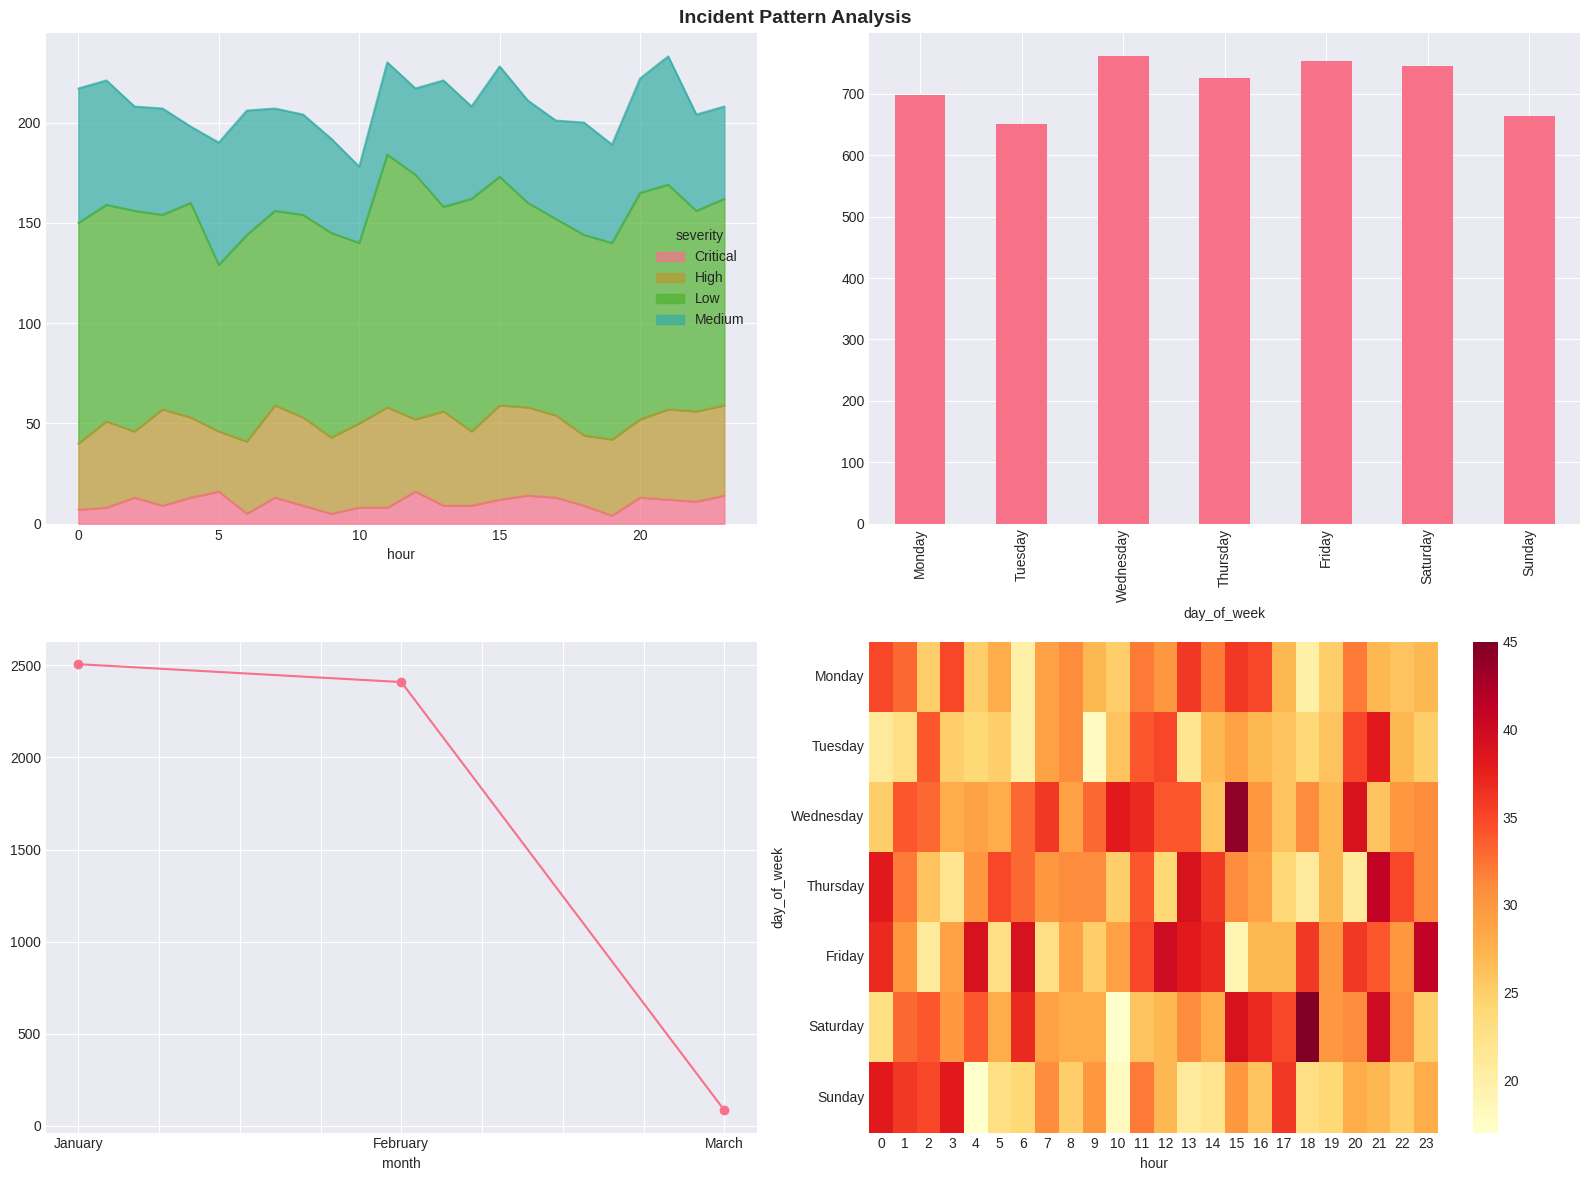


PATTERN INSIGHTS:
 Peak incident hour: 21:00
 Peak incident day: Wednesday
 Peak incident month: January


In [15]:
# Hourly and weekly patterns
def analyze_patterns(incidents_clean):
    """Analyze hourly, weekly, and monthly patterns"""
    print("\nPATTERN ANALYSIS")

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Incident Pattern Analysis', fontsize=14, fontweight='bold')

    hourly_severity = pd.crosstab(incidents_clean['hour'], incidents_clean['severity'])
    hourly_severity.plot(kind='area', stacked=True, ax=axes[0,0], alpha=0.7)

    day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    weekly_pattern = incidents_clean.groupby('day_of_week').size().reindex(day_order)
    weekly_pattern.plot(kind='bar', ax=axes[0,1])

    month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
    monthly_pattern = incidents_clean.groupby('month').size().reindex(month_order)
    monthly_pattern.plot(kind='line', marker='o', ax=axes[1,0])

    heatmap_data = pd.crosstab(incidents_clean['day_of_week'], incidents_clean['hour']).reindex(day_order)
    sns.heatmap(heatmap_data, cmap='YlOrRd', ax=axes[1,1])

    plt.tight_layout()
    plt.show()

    print("\nPATTERN INSIGHTS:")
    print(f" Peak incident hour: {incidents_clean.groupby('hour').size().idxmax()}:00")
    print(f" Peak incident day: {weekly_pattern.idxmax()}")
    print(f" Peak incident month: {monthly_pattern.idxmax()}")


analyze_patterns(incidents_clean)

<a id="geographic"></a>
## 5. Geographic Analysis

Analyzing incident distribution across geographic locations and identify regional patterns.

In [17]:
# Geographic analysis
def geographic_analysis(incidents_clean):
    """Perform comprehensive geographic analysis"""
    print("🌍 GEOGRAPHIC ANALYSIS")
    print("=" * 60)

    # Location statistics
    location_stats = incidents_clean.groupby('location').agg({
        'event_id': 'count',
        'severity_score': 'mean',
        'source_ip': 'nunique'
    }).rename(columns={
        'event_id': 'total_incidents',
        'severity_score': 'avg_severity',
        'source_ip': 'unique_ips'
    }).sort_values('total_incidents', ascending=False)

    print("\n📊 TOP 10 LOCATIONS BY INCIDENT COUNT:")
    display(location_stats.head(10))

    # Geographic visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🌍 Geographic Security Analysis', fontsize=14, fontweight='bold')

    # Top locations by incident count
    top_locations = location_stats.head(10)
    top_locations['total_incidents'].plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('Top 10 Locations by Incident Count')
    axes[0,0].set_xlabel('Location')
    axes[0,0].set_ylabel('Total Incidents')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Average severity by location
    top_locations['avg_severity'].plot(kind='bar', ax=axes[0,1], color='salmon')
    axes[0,1].set_title('Average Severity Score by Location')
    axes[0,1].set_xlabel('Location')
    axes[0,1].set_ylabel('Average Severity Score')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].axhline(
        y=location_stats['avg_severity'].mean(),
        color='red',
        linestyle='--',
        label=f'Global Average: {location_stats["avg_severity"].mean():.2f}'
    )
    axes[0,1].legend()

    # Unique IPs by location
    top_locations['unique_ips'].plot(kind='bar', ax=axes[1,0], color='lightgreen')
    axes[1,0].set_title('Unique Source IPs by Location')
    axes[1,0].set_xlabel('Location')
    axes[1,0].set_ylabel('Unique IPs')
    axes[1,0].tick_params(axis='x', rotation=45)

    # Severity distribution by location
    severity_by_location = pd.crosstab(
        incidents_clean['location'],
        incidents_clean['severity']
    )
    severity_by_location = (
        severity_by_location
        .div(severity_by_location.sum(axis=1), axis=0) * 100
    )

    top_severity_locations = severity_by_location.loc[top_locations.index]
    top_severity_locations.plot(
        kind='bar',
        stacked=True,
        ax=axes[1,1],
        color=['green', 'yellow', 'orange', 'red']
    )
    axes[1,1].set_title('Severity Distribution by Location (%)')
    axes[1,1].set_xlabel('Location')
    axes[1,1].set_ylabel('Percentage')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].legend(
        title='Severity',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )

    plt.tight_layout()
    plt.show()

    # Geographic insights
    print("\n🌍 GEOGRAPHIC INSIGHTS:")

    # High-risk locations
    high_risk_locations = location_stats[
        location_stats['avg_severity']
        > location_stats['avg_severity'].quantile(0.75)
    ]
    print(
        f" High-risk locations (>75th percentile severity): "
        f"{len(high_risk_locations)}"
    )

    if len(high_risk_locations) > 0:
        print(
            f" Top high-risk: {high_risk_locations.index[0]} "
            f"(severity: {high_risk_locations['avg_severity'].iloc[0]:.2f})"
        )

    # Most active locations
    most_active = location_stats.index[0]
    most_active_count = location_stats['total_incidents'].iloc[0]
    print(
        f" Most active location: {most_active} "
        f"({most_active_count} incidents)"
    )

    # Location diversity
    print(f" Total locations affected: {len(location_stats)}")
    print(
        f" Average incidents per location: "
        f"{location_stats['total_incidents'].mean():.1f}"
    )

    # Critical incident hotspots
    critical_by_location = (
        incidents_clean[incidents_clean['severity'] == 'Critical']
        .groupby('location')
        .size()
    )

    if len(critical_by_location) > 0:
        critical_hotspot = critical_by_location.idxmax()
        critical_count = critical_by_location.max()
        print(
            f" Critical incident hotspot: {critical_hotspot} "
            f"({critical_count} critical incidents)"
        )

    return location_stats


🌍 GEOGRAPHIC ANALYSIS

📊 TOP 10 LOCATIONS BY INCIDENT COUNT:


,total_incidents,avg_severity,unique_ips
location,,,
USA,855,1.835088,855
Egypt,840,1.817857,840
Germany,830,1.751807,830
KSA,829,1.785283,829
UAE,828,1.770531,828
Unknown,818,1.799511,818


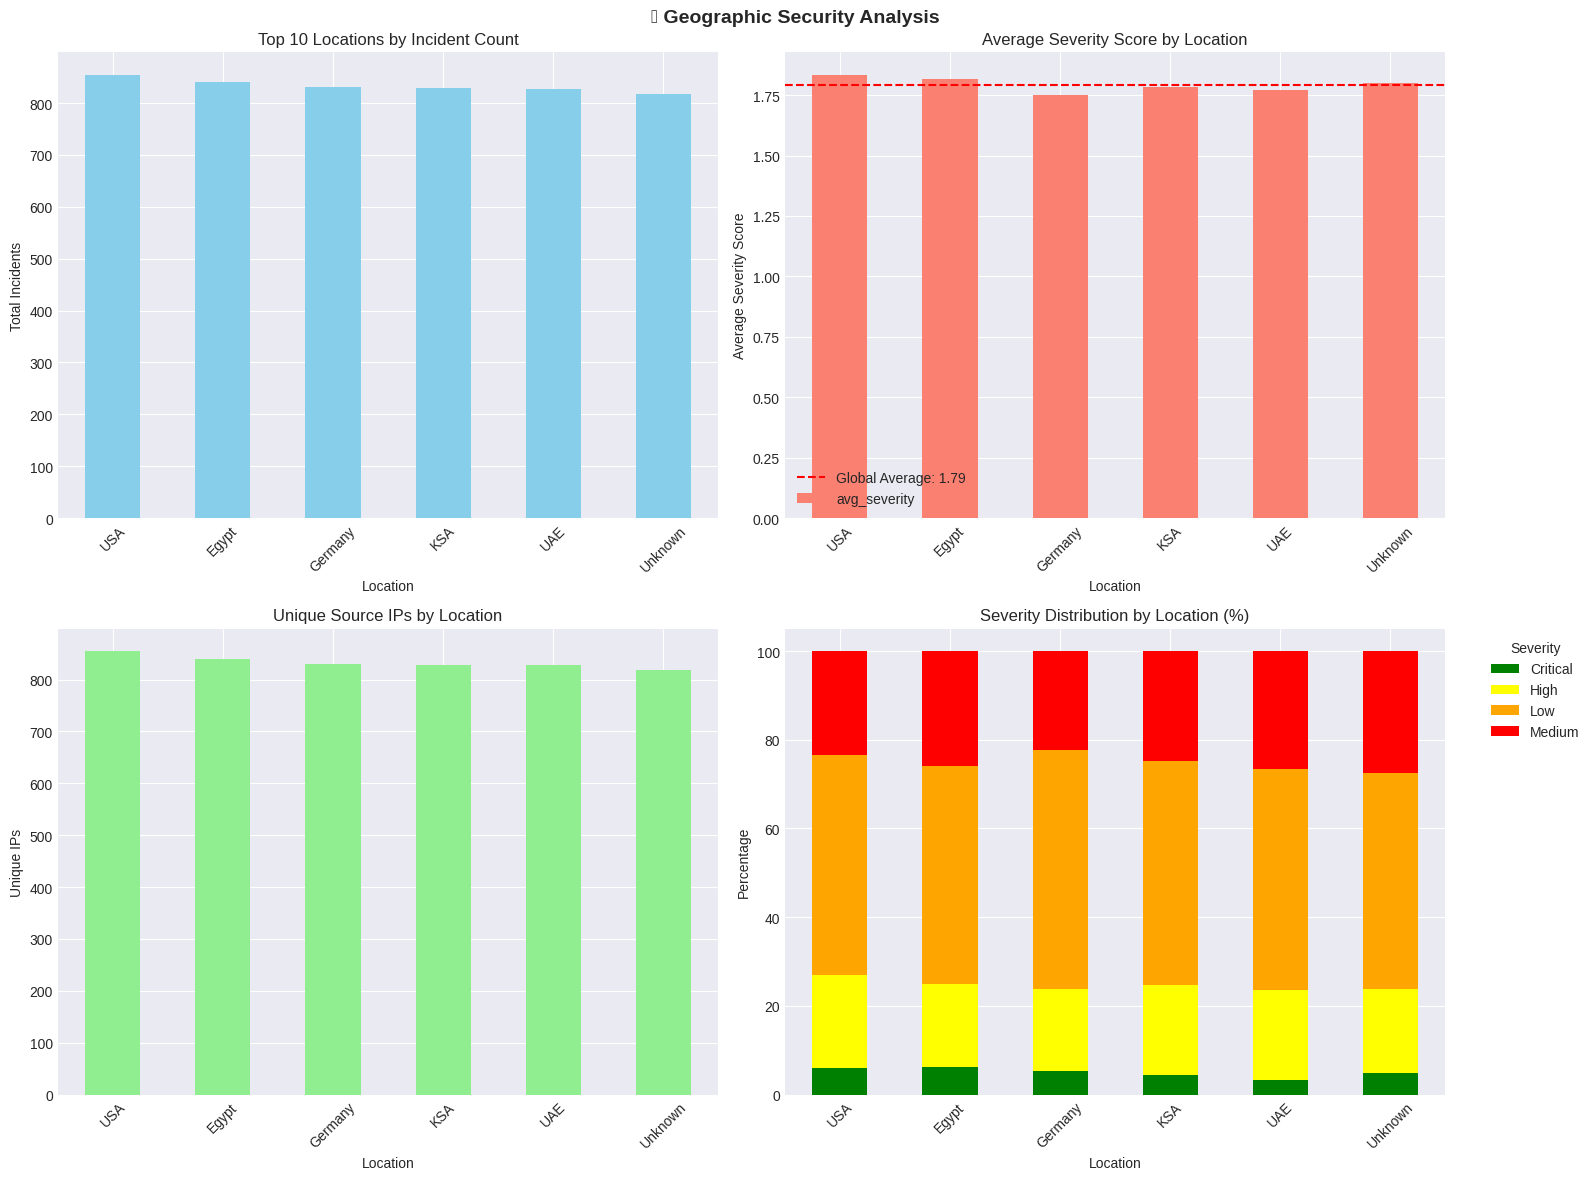


🌍 GEOGRAPHIC INSIGHTS:
 High-risk locations (>75th percentile severity): 2
 Top high-risk: USA (severity: 1.84)
 Most active location: USA (855 incidents)
 Total locations affected: 6
 Average incidents per location: 833.3
 Critical incident hotspot: Egypt (52 critical incidents)


In [18]:
# Perform geographic analysis
location_stats = geographic_analysis(incidents_clean)


<a id="risk-scoring"></a>
## 6. Risk Scoring & Assessment

Implementing various risk scoring algorithms and create comprehensive risk assessments.

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

class RiskScorer:
    """Comprehensive risk scoring system"""

    def calculate_basic_risk_score(self, df):
        df = df.copy()
        df['basic_risk_score'] = df['severity_score'] * 100
        return df

    def calculate_advanced_risk_score(self, df):
        df = df.copy()
        df['advanced_risk_score'] = df['severity_score'] * 100

        event_freq = df['event_type'].value_counts()
        df['event_rarity'] = df['event_type'].map(
            lambda x: 1 / (event_freq[x] / len(df))
        )
        df['advanced_risk_score'] *= (1 + df['event_rarity'] / 10)

        df['business_hours'] = df['hour'].between(9, 17)
        df['advanced_risk_score'] *= np.where(df['business_hours'], 1, 1.3)

        return df

    def calculate_temporal_risk_score(self, df):
        df = df.sort_values('timestamp')
        df['rolling_incidents_24h'] = df.rolling(
            '24H', on='timestamp'
        )['event_id'].count()

        df['temporal_risk_score'] = (
            df['severity_score'] * 100 *
            (1 + df['rolling_incidents_24h'] / 10)
        )
        return df

    def calculate_anomaly_score(self, df):
        features = pd.DataFrame({
            'hour': df['hour'],
            'severity_score': df['severity_score'],
            'event_type': pd.Categorical(df['event_type']).codes
        })

        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        iso = IsolationForest(contamination=0.1, random_state=42)
        preds = iso.fit_predict(features_scaled)

        df['anomaly_score'] = (-preds + 1) * 50
        return df

    def calculate_geographic_risk_score(self, df):
        location_stats = df.groupby('location').agg({
            'severity_score': 'mean',
            'event_id': 'count',
            'source_ip': 'nunique'
        })

        norm = lambda x: (x - x.min()) / (x.max() - x.min())
        location_stats['geo_risk_score'] = (
            norm(location_stats['severity_score']) * 0.5 +
            norm(location_stats['event_id']) * 0.3 +
            norm(location_stats['source_ip']) * 0.2
        ) * 100

        df['geo_risk_score'] = df['location'].map(
            location_stats['geo_risk_score']
        )
        return df

    def calculate_ensemble_risk_score(self, df):
        df = self.calculate_basic_risk_score(df)
        df = self.calculate_advanced_risk_score(df)
        df = self.calculate_temporal_risk_score(df)
        df = self.calculate_anomaly_score(df)
        df = self.calculate_geographic_risk_score(df)

        score_cols = [
            'basic_risk_score',
            'advanced_risk_score',
            'temporal_risk_score',
            'anomaly_score',
            'geo_risk_score'
        ]
        weights = [0.25, 0.25, 0.2, 0.15, 0.15]

        df['ensemble_risk_score'] = 0
        for col, w in zip(score_cols, weights):
            norm = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
            df['ensemble_risk_score'] += norm * w * 100

        df['final_risk_level'] = pd.cut(
            df['ensemble_risk_score'],
            bins=[0, 30, 55, 80, np.inf],
            labels=['Low', 'Medium', 'High', 'Critical']
        )

        return df.sort_values('ensemble_risk_score', ascending=False)


In [20]:
# Run risk scoring
risk_scorer = RiskScorer()
incidents_with_risk = risk_scorer.calculate_ensemble_risk_score(incidents_clean)

# Risk distribution
incidents_with_risk['final_risk_level'].value_counts()


final_risk_level
Low         3297
Medium      1186
High         346
Critical     171
Name: count, dtype: int64

## Risk Analysis Visualization


📊 RISK ANALYSIS VISUALIZATION


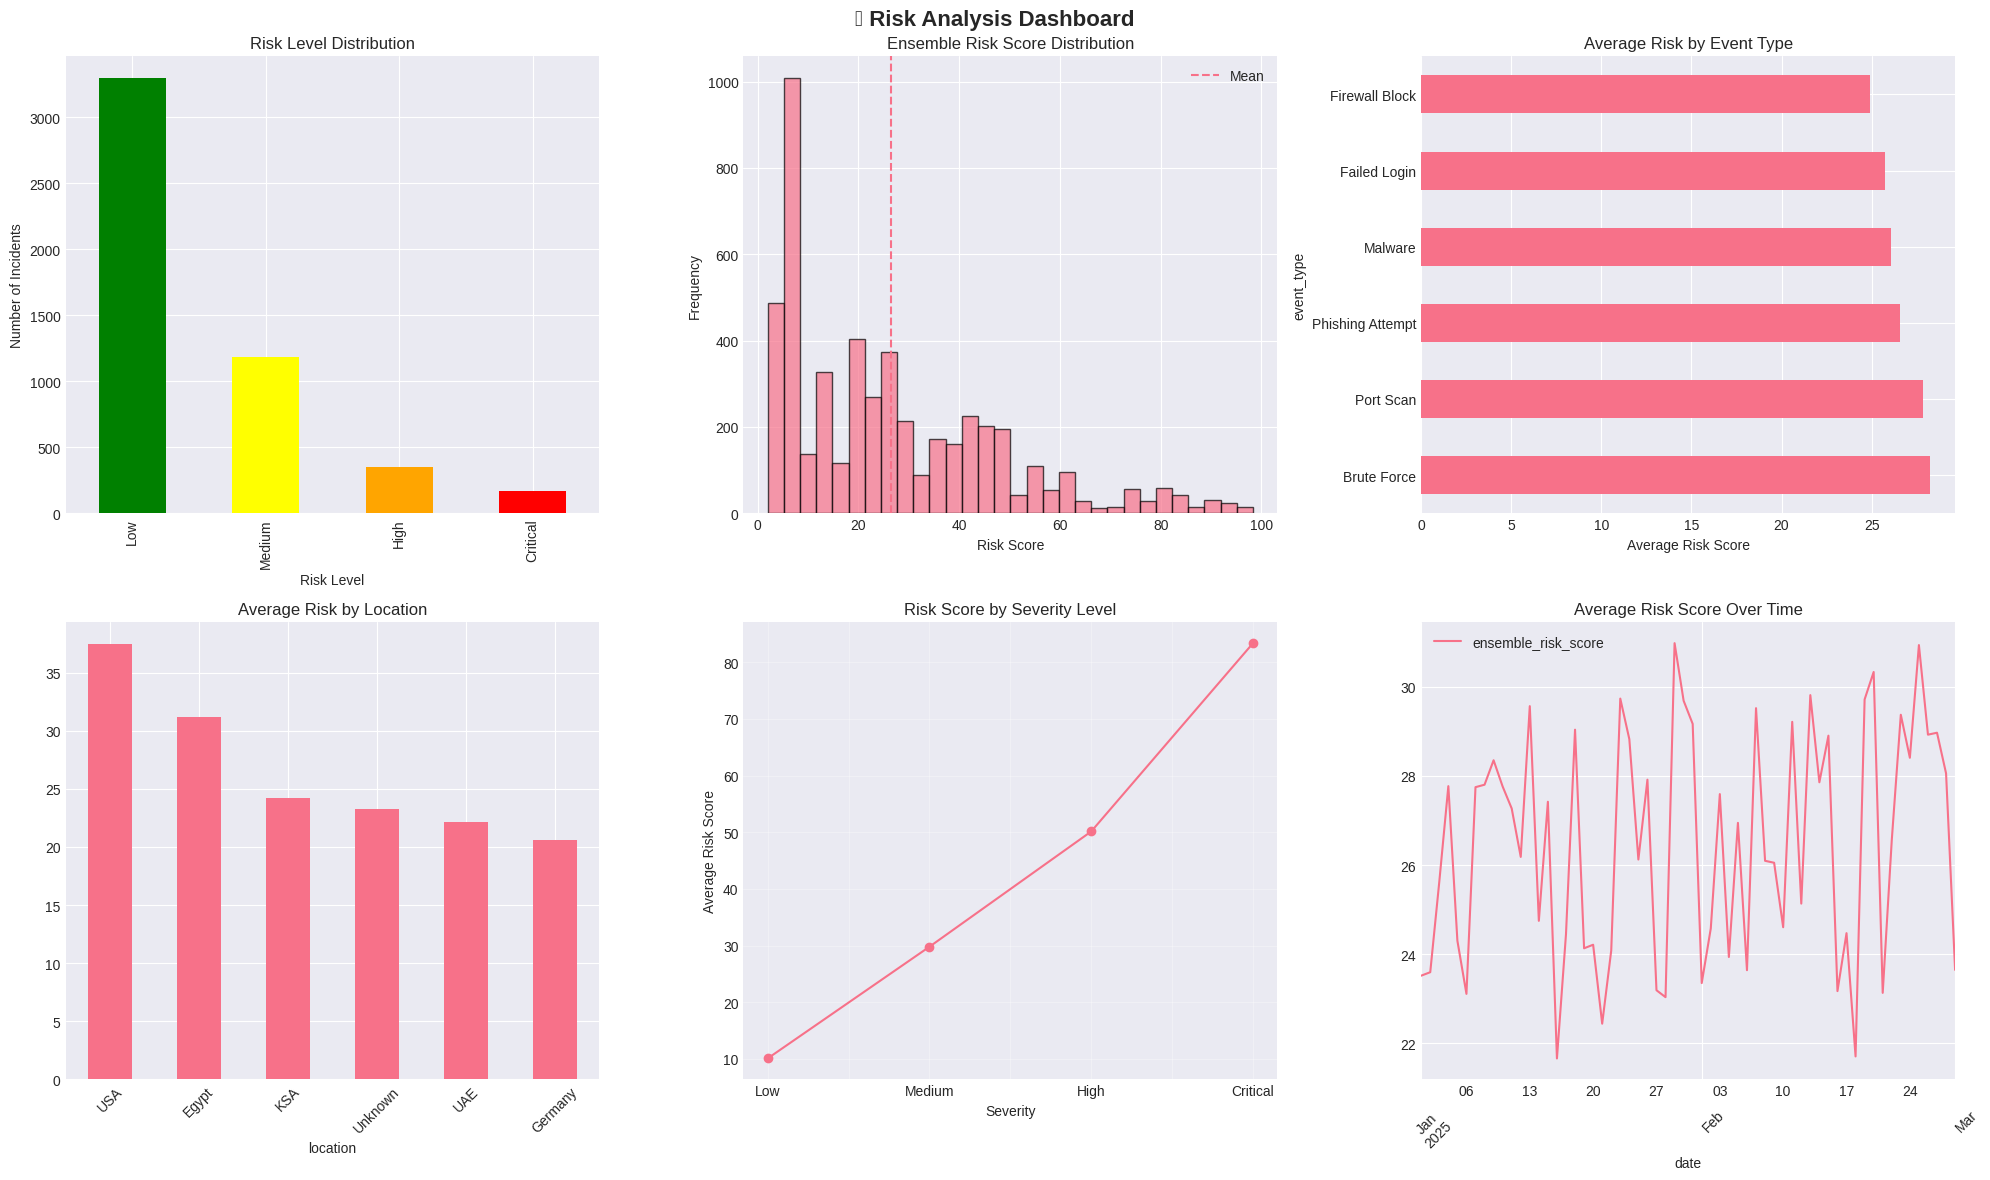

In [21]:
# Risk visualization
def visualize_risk_analysis(incidents_with_risk):
    """Create comprehensive risk analysis visualizations"""
    print("\n📊 RISK ANALYSIS VISUALIZATION")
    print("="*60)
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('🎯 Risk Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # Risk level distribution
    risk_colors = {'Low': 'green', 'Medium': 'yellow', 'High': 'orange', 'Critical': 'red'}
    risk_counts = incidents_with_risk['final_risk_level'].value_counts().sort_index()
    risk_counts.plot(
        kind='bar',
        ax=axes[0,0],
        color=[risk_colors.get(x, 'blue') for x in risk_counts.index]
    )
    axes[0,0].set_title('Risk Level Distribution')
    axes[0,0].set_xlabel('Risk Level')
    axes[0,0].set_ylabel('Number of Incidents')
    
    # Risk score distribution
    axes[0,1].hist(
        incidents_with_risk['ensemble_risk_score'],
        bins=30,
        alpha=0.7,
        edgecolor='black'
    )
    axes[0,1].set_title('Ensemble Risk Score Distribution')
    axes[0,1].set_xlabel('Risk Score')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].axvline(
        incidents_with_risk['ensemble_risk_score'].mean(),
        linestyle='--',
        label='Mean'
    )
    axes[0,1].legend()
    
    # Risk by event type
    risk_by_event = (
        incidents_with_risk
        .groupby('event_type')['ensemble_risk_score']
        .mean()
        .sort_values(ascending=False)
        .head(10)
    )
    risk_by_event.plot(kind='barh', ax=axes[0,2])
    axes[0,2].set_title('Average Risk by Event Type')
    axes[0,2].set_xlabel('Average Risk Score')
    
    # Risk by location
    risk_by_location = (
        incidents_with_risk
        .groupby('location')['ensemble_risk_score']
        .mean()
        .sort_values(ascending=False)
        .head(10)
    )
    risk_by_location.plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Average Risk by Location')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Risk vs severity
    severity_risk = (
        incidents_with_risk
        .groupby('severity')['ensemble_risk_score']
        .mean()
        .reindex(['Low', 'Medium', 'High', 'Critical'])
    )
    severity_risk.plot(kind='line', marker='o', ax=axes[1,1])
    axes[1,1].set_title('Risk Score by Severity Level')
    axes[1,1].set_xlabel('Severity')
    axes[1,1].set_ylabel('Average Risk Score')
    axes[1,1].grid(True, alpha=0.3)
    
    # Risk over time
    daily_risk = (
        incidents_with_risk
        .groupby('date')['ensemble_risk_score']
        .mean()
        .reset_index()
    )
    daily_risk['date'] = pd.to_datetime(daily_risk['date'])
    daily_risk.sort_values('date').plot(
        x='date',
        y='ensemble_risk_score',
        ax=axes[1,2]
    )
    axes[1,2].set_title('Average Risk Score Over Time')
    axes[1,2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


visualize_risk_analysis(incidents_with_risk)


<a id="anomaly-detection"></a>
## 7. Anomaly Detection

Implementing advanced anomaly detection algorithms to identify unusual patterns and potential security threats.

In [22]:
# Advanced anomaly detection
def advanced_anomaly_detection(incidents_clean):
    """Implement multiple anomaly detection techniques"""
    print("🔍 ADVANCED ANOMALY DETECTION")
    print("="*60)
    
    features_df = incidents_clean.copy()
    
    # Encode categorical variables
    le_event = LabelEncoder()
    le_location = LabelEncoder()
    
    features_df['event_type_encoded'] = le_event.fit_transform(features_df['event_type'])
    features_df['location_encoded'] = le_location.fit_transform(
        features_df['location'].fillna('Unknown')
    )
    
    feature_cols = ['hour', 'severity_score', 'event_type_encoded', 'location_encoded']
    X = features_df[feature_cols]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print("\n🤖 APPLYING ANOMALY DETECTION ALGORITHMS:")
    
    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_pred = iso_forest.fit_predict(X_scaled)
    iso_score = -iso_forest.decision_function(X_scaled)
    
    # Z-score
    from scipy.stats import zscore
    z_outliers = (np.abs(zscore(X_scaled)) > 3).any(axis=1)
    
    features_df['iso_anomaly'] = (iso_pred == -1).astype(int)
    features_df['iso_score'] = iso_score
    features_df['zscore_anomaly'] = z_outliers.astype(int)
    
    features_df['ensemble_anomaly_score'] = (
        features_df['iso_score'] * 0.7 +
        features_df['zscore_anomaly'] * 20
    )
    
    top_anomalies = features_df.nlargest(
        20, 'ensemble_anomaly_score'
    )[
        [
            'timestamp', 'event_type', 'severity',
            'source_ip', 'location',
            'ensemble_anomaly_score'
        ]
    ]
    
    display(top_anomalies)
    
    return features_df, top_anomalies


incidents_with_anomalies, top_anomalies = advanced_anomaly_detection(incidents_clean)


🔍 ADVANCED ANOMALY DETECTION

🤖 APPLYING ANOMALY DETECTION ALGORITHMS:


,timestamp,event_type,severity,source_ip,location,ensemble_anomaly_score
4307,2025-02-05 21:58:00,Port Scan,Critical,56.158.147.222,Unknown,0.047731
2534,2025-02-13 21:29:00,Brute Force,Critical,142.112.27.250,Egypt,0.042167
1709,2025-02-12 23:46:00,Failed Login,Critical,69.125.88.158,Egypt,0.039788
3839,2025-01-30 00:00:00,Phishing Attempt,Critical,57.41.84.194,Unknown,0.039650
1756,2025-01-22 22:21:00,Phishing Attempt,Critical,171.236.218.145,Unknown,0.039484
4405,2025-01-25 19:43:00,Brute Force,Critical,60.249.233.136,Egypt,0.039093
546,2025-01-15 21:25:00,Port Scan,Critical,129.21.220.223,Egypt,0.039031
1264,2025-02-16 21:25:00,Port Scan,Critical,158.112.122.20,Egypt,0.039031
725,2025-01-07 20:22:00,Brute Force,Critical,80.209.83.205,Unknown,0.038617
3530,2025-01-05 23:50:00,Port Scan,Critical,7.86.247.195,USA,0.038332


<a id="correlation"></a>
## 8. Correlation Analysis

Analyzing correlations between incidents, login activity, and various security metrics.

🔗 COMPREHENSIVE CORRELATION ANALYSIS

📊 DAILY CORRELATION MATRIX:


,incident_count,avg_severity,unique_ips,total_logins,successful_logins,failed_logins,login_success_rate
incident_count,1.000,0.199,1.000,-0.063,0.037,-0.106,0.128
avg_severity,0.199,1.000,0.199,0.182,-0.028,0.249,-0.203
unique_ips,1.000,0.199,1.000,-0.063,0.037,-0.106,0.128
total_logins,-0.063,0.182,-0.063,1.000,0.597,0.795,-0.234
successful_logins,0.037,-0.028,0.037,0.597,1.000,-0.012,0.632
failed_logins,-0.106,0.249,-0.106,0.795,-0.012,1.000,-0.769
login_success_rate,0.128,-0.203,0.128,-0.234,0.632,-0.769,1.000



🔍 KEY CORRELATION INSIGHTS:
 Daily incidents vs total logins: -0.063
 Daily incidents vs failed logins: -0.106
 Average severity vs login success rate: -0.203
 Unique IPs vs incident count: 1.000

📈 STATISTICAL SIGNIFICANCE TESTS:
 Incidents vs Failed Logins - Correlation: -0.106, P-value: 0.419
 → No statistically significant correlation
 Spearman correlation: -0.098, P-value: 0.457


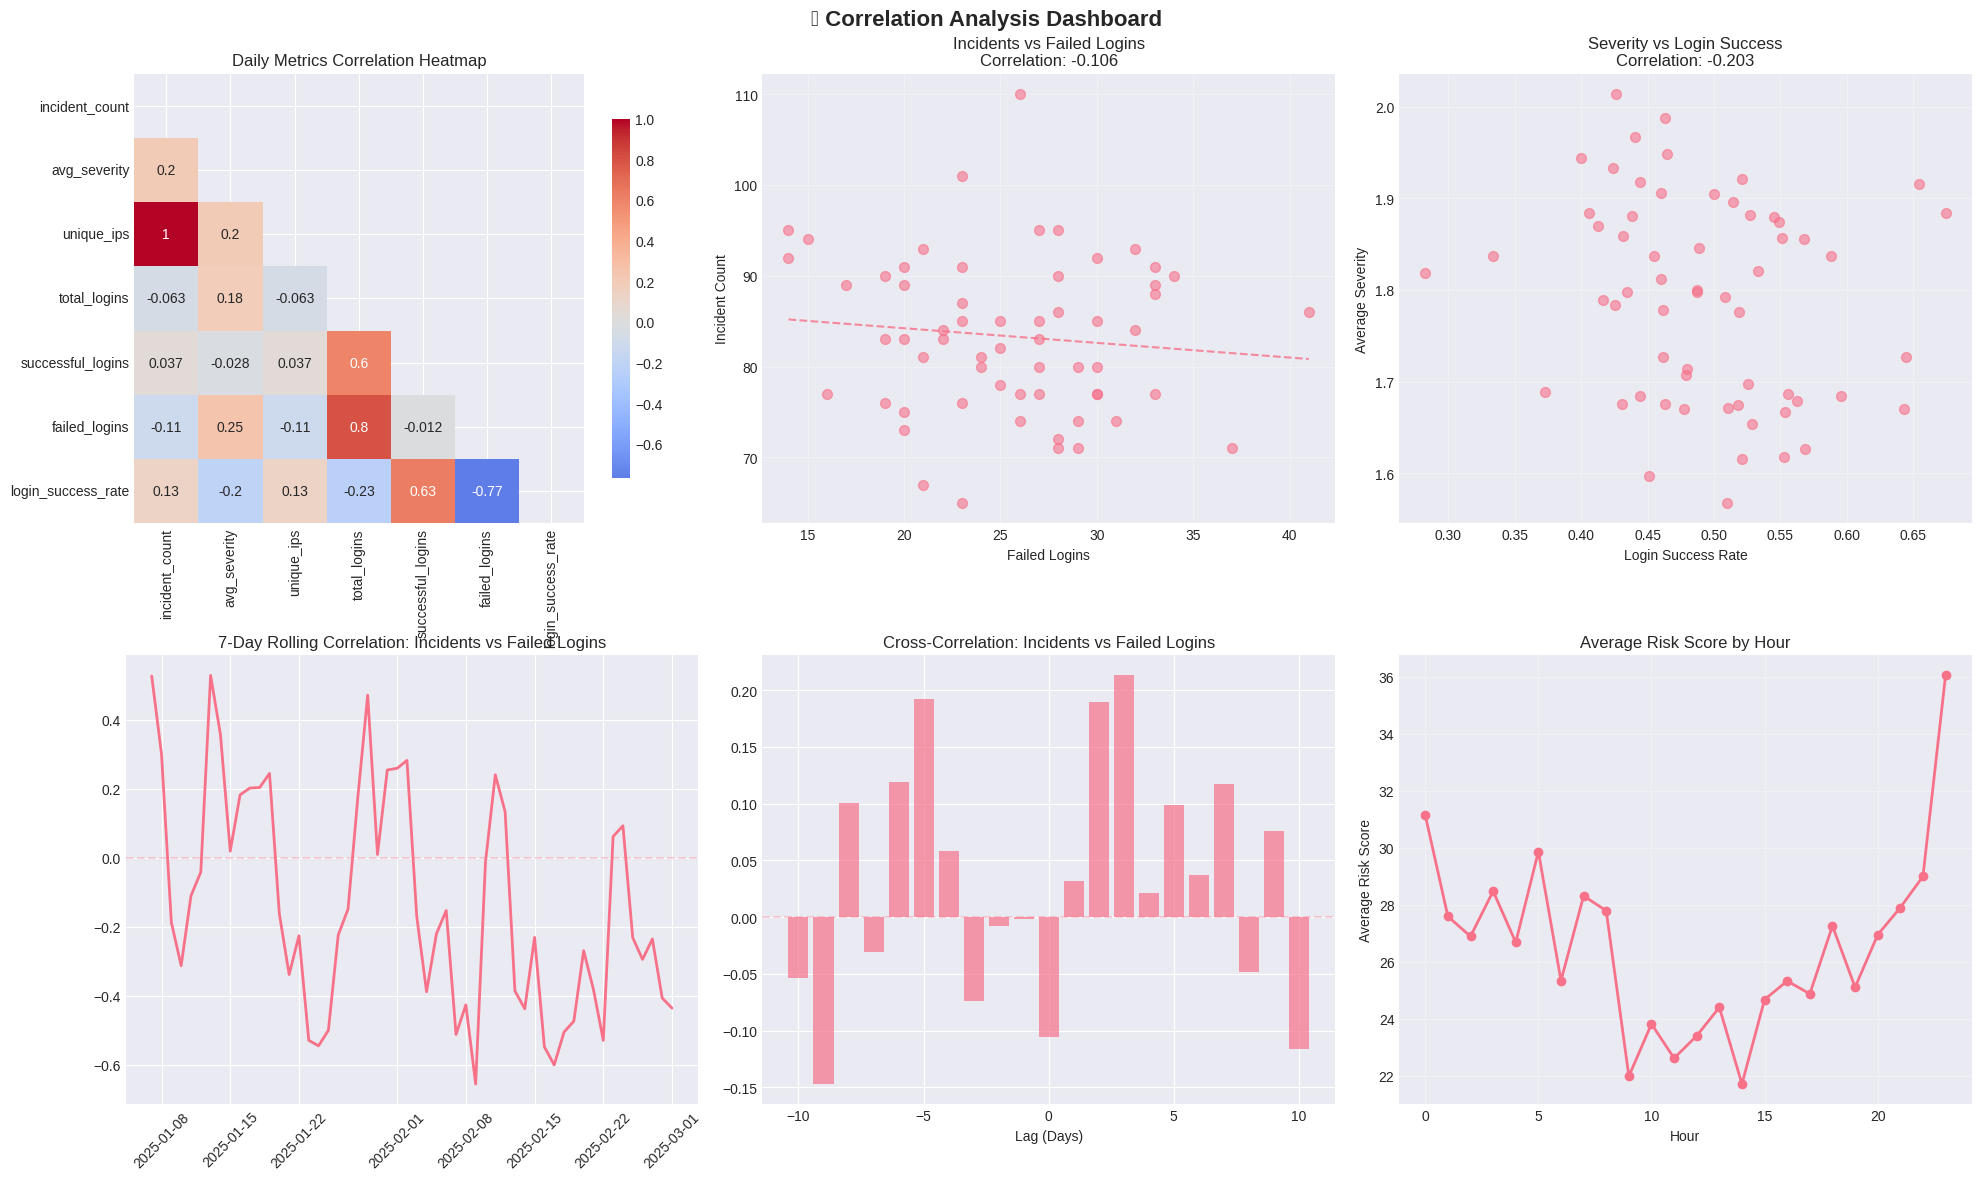

In [23]:
# Comprehensive correlation analysis
def correlation_analysis(incidents_clean, logins_clean, incidents_with_risk):
    """Perform comprehensive correlation analysis between security metrics"""
    print("🔗 COMPREHENSIVE CORRELATION ANALYSIS")
    print("="*60)
    
    # =========================
    # 1. Daily aggregations
    # =========================
    daily_incidents = incidents_clean.groupby('date').agg({
        'event_id': 'count',
        'severity_score': 'mean',
        'source_ip': 'nunique'
    }).rename(columns={
        'event_id': 'incident_count',
        'severity_score': 'avg_severity',
        'source_ip': 'unique_ips'
    })
    
    daily_logins = logins_clean.groupby('date').agg({
        'login_id': 'count',
        'success': lambda x: (x == 'Yes').sum()
    }).rename(columns={
        'login_id': 'total_logins',
        'success': 'successful_logins'
    })
    
    daily_logins['failed_logins'] = (
        daily_logins['total_logins'] - daily_logins['successful_logins']
    )
    daily_logins['login_success_rate'] = (
        daily_logins['successful_logins'] / daily_logins['total_logins']
    )
    
    # Merge datasets
    daily_merged = (
        pd.merge(
            daily_incidents,
            daily_logins,
            left_index=True,
            right_index=True,
            how='outer'
        )
        .fillna(0)
    )
    
    # =========================
    # Correlation matrix
    # =========================
    print("\n📊 DAILY CORRELATION MATRIX:")
    daily_corr = daily_merged.corr()
    display(daily_corr.round(3))
    
    # =========================
    # Key correlations
    # =========================
    print("\n🔍 KEY CORRELATION INSIGHTS:")
    
    incident_login_corr = daily_merged['incident_count'].corr(
        daily_merged['total_logins']
    )
    print(f" Daily incidents vs total logins: {incident_login_corr:.3f}")
    
    incident_failed_corr = daily_merged['incident_count'].corr(
        daily_merged['failed_logins']
    )
    print(f" Daily incidents vs failed logins: {incident_failed_corr:.3f}")
    
    severity_success_corr = daily_merged['avg_severity'].corr(
        daily_merged['login_success_rate']
    )
    print(f" Average severity vs login success rate: {severity_success_corr:.3f}")
    
    ip_incident_corr = daily_merged['unique_ips'].corr(
        daily_merged['incident_count']
    )
    print(f" Unique IPs vs incident count: {ip_incident_corr:.3f}")
    
    # =========================
    # Statistical tests
    # =========================
    print("\n📈 STATISTICAL SIGNIFICANCE TESTS:")
    
    corr_coef, p_value = pearsonr(
        daily_merged['incident_count'],
        daily_merged['failed_logins']
    )
    print(
        f" Incidents vs Failed Logins - "
        f"Correlation: {corr_coef:.3f}, P-value: {p_value:.3f}"
    )
    print(
        " → Statistically significant correlation!"
        if p_value < 0.05 else
        " → No statistically significant correlation"
    )
    
    spearman_corr, spearman_p = spearmanr(
        daily_merged['incident_count'],
        daily_merged['failed_logins']
    )
    print(
        f" Spearman correlation: {spearman_corr:.3f}, "
        f"P-value: {spearman_p:.3f}"
    )
    
    # =========================
    # Visualizations
    # =========================
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(
        '🔗 Correlation Analysis Dashboard',
        fontsize=16,
        fontweight='bold'
    )
    
    # Heatmap
    mask = np.triu(np.ones_like(daily_corr, dtype=bool))
    sns.heatmap(
        daily_corr,
        mask=mask,
        annot=True,
        cmap='coolwarm',
        center=0,
        square=True,
        ax=axes[0,0],
        cbar_kws={'shrink': 0.8}
    )
    axes[0,0].set_title('Daily Metrics Correlation Heatmap')
    
    # Scatter: incidents vs failed logins
    axes[0,1].scatter(
        daily_merged['failed_logins'],
        daily_merged['incident_count'],
        alpha=0.6,
        s=50
    )
    axes[0,1].set_xlabel('Failed Logins')
    axes[0,1].set_ylabel('Incident Count')
    axes[0,1].set_title(
        f'Incidents vs Failed Logins\n'
        f'Correlation: {incident_failed_corr:.3f}'
    )
    axes[0,1].grid(True, alpha=0.3)
    
    if len(daily_merged) > 1:
        z = np.polyfit(
            daily_merged['failed_logins'],
            daily_merged['incident_count'],
            1
        )
        p = np.poly1d(z)
        x_trend = np.linspace(
            daily_merged['failed_logins'].min(),
            daily_merged['failed_logins'].max(),
            100
        )
        axes[0,1].plot(x_trend, p(x_trend), "--", alpha=0.8)
    
    # Scatter: severity vs login success
    valid_data = daily_merged.dropna(
        subset=['avg_severity', 'login_success_rate']
    )
    if len(valid_data) > 0:
        axes[0,2].scatter(
            valid_data['login_success_rate'],
            valid_data['avg_severity'],
            alpha=0.6,
            s=50
        )
        corr_sev_success = valid_data['avg_severity'].corr(
            valid_data['login_success_rate']
        )
        axes[0,2].set_title(
            f'Severity vs Login Success\n'
            f'Correlation: {corr_sev_success:.3f}'
        )
        axes[0,2].set_xlabel('Login Success Rate')
        axes[0,2].set_ylabel('Average Severity')
        axes[0,2].grid(True, alpha=0.3)
    
    # Rolling correlation
    rolling_corr = (
        daily_merged['incident_count']
        .rolling(window=7)
        .corr(daily_merged['failed_logins'])
    )
    axes[1,0].plot(daily_merged.index, rolling_corr, linewidth=2)
    axes[1,0].axhline(0, linestyle='--', alpha=0.3)
    axes[1,0].set_title(
        '7-Day Rolling Correlation: Incidents vs Failed Logins'
    )
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Cross-correlation
    max_lags = min(10, len(daily_merged) - 1)
    lags = list(range(-max_lags, max_lags + 1))
    cross_corr = [
        daily_merged['incident_count'].corr(
            daily_merged['failed_logins'].shift(lag)
        )
        for lag in lags
    ]
    axes[1,1].bar(lags, cross_corr, alpha=0.7)
    axes[1,1].axhline(0, linestyle='--', alpha=0.3)
    axes[1,1].set_title(
        'Cross-Correlation: Incidents vs Failed Logins'
    )
    axes[1,1].set_xlabel('Lag (Days)')
    
    # Risk score vs hour
    if 'ensemble_risk_score' in incidents_with_risk.columns:
        risk_by_hour = (
            incidents_with_risk
            .groupby('hour')['ensemble_risk_score']
            .mean()
        )
        axes[1,2].plot(
            risk_by_hour.index,
            risk_by_hour.values,
            marker='o',
            linewidth=2
        )
        axes[1,2].set_title('Average Risk Score by Hour')
        axes[1,2].set_xlabel('Hour')
        axes[1,2].set_ylabel('Average Risk Score')
        axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    insights = {
        'incident_login_corr': incident_login_corr,
        'incident_failed_corr': incident_failed_corr,
        'severity_success_corr': severity_success_corr,
        'ip_incident_corr': ip_incident_corr,
        'rolling_corr_mean': rolling_corr.mean(),
        'cross_corr_max': max(cross_corr),
        'cross_corr_lag': lags[cross_corr.index(max(cross_corr))]
    }
    
    return insights, daily_corr


correlation_insights, daily_correlation_matrix = correlation_analysis(
    incidents_clean,
    logins_clean,
    incidents_with_risk
)


<a id="attack-patterns"></a>
## 9. Attack Pattern Recognition

Identifying common attack patterns, sequences, and behavioral indicators of compromise.

In [26]:
# Attack pattern recognition and analysis
def attack_pattern_analysis(incidents_clean):
    """Analyze attack patterns and sequences"""
    print("🎯 ATTACK PATTERN RECOGNITION")
    print("="*60)
    
    # Sort incidents by timestamp for sequence analysis
    incidents_sorted = incidents_clean.sort_values('timestamp').copy()
    
    # 1. Event type sequences
    print("\n🔄 ANALYZING EVENT SEQUENCES:")
    
    ip_sequences = {}
    for ip in incidents_sorted['source_ip'].unique():
        ip_events = incidents_sorted[incidents_sorted['source_ip'] == ip]
        if len(ip_events) >= 3:
            sequence = ' → '.join(ip_events['event_type'].tolist())
            ip_sequences[ip] = {
                'sequence': sequence,
                'count': len(ip_events),
                'severity': (
                    ip_events['severity'].mode().iloc[0]
                    if len(ip_events['severity'].mode()) > 0 else 'Mixed'
                ),
                'time_span': (
                    ip_events['timestamp'].max()
                    - ip_events['timestamp'].min()
                ).total_seconds() / 3600
            }
    
    sequence_counts = {}
    for ip, data in ip_sequences.items():
        seq = data['sequence']
        if seq in sequence_counts:
            sequence_counts[seq]['ips'].append(ip)
            sequence_counts[seq]['count'] += 1
        else:
            sequence_counts[seq] = {
                'ips': [ip],
                'count': 1,
                'avg_time_span': data['time_span']
            }
    
    print("\n📋 COMMON ATTACK SEQUENCES:")
    common_sequences = sorted(
        sequence_counts.items(),
        key=lambda x: x[1]['count'],
        reverse=True
    )[:10]
    
    for i, (sequence, data) in enumerate(common_sequences, 1):
        print(f" {i}. {sequence}")
        print(f" Occurs: {data['count']} times")
        print(f" IPs involved: {len(data['ips'])}")
        print(f" Avg time span: {data['avg_time_span']:.1f} hours\n")
    
    # 2. Behavioral analysis
    print("\n🧠 BEHAVIORAL PATTERN ANALYSIS:")
    
    ip_behavior = incidents_sorted.groupby('source_ip').agg({
        'event_id': 'count',
        'event_type': 'nunique',
        'severity': lambda x: x.value_counts().index[0],
        'hour': 'std',
        'timestamp': lambda x: (
            x.max() - x.min()
        ).total_seconds() / 3600,
        'location': lambda x: x.nunique()
    }).rename(columns={
        'event_id': 'total_events',
        'event_type': 'unique_event_types',
        'severity': 'primary_severity',
        'hour': 'timing_variability',
        'timestamp': 'activity_span_hours',
        'location': 'location_diversity'
    })
    
    active_ips = ip_behavior[ip_behavior['total_events'] >= 3]
    
    if len(active_ips) >= 5:
        cluster_features = [
            'total_events',
            'unique_event_types',
            'activity_span_hours',
            'location_diversity'
        ]
        X_cluster = active_ips[cluster_features].fillna(0)
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_cluster)
        
        n_clusters = min(4, len(active_ips))
        kmeans = KMeans(
            n_clusters=n_clusters,
            random_state=42,
            n_init=10
        )
        active_ips['behavior_cluster'] = kmeans.fit_predict(X_scaled)
        
        cluster_summary = active_ips.groupby('behavior_cluster').agg({
            'total_events': ['mean', 'count'],
            'unique_event_types': 'mean',
            'activity_span_hours': 'mean',
            'primary_severity': (
                lambda x: x.mode().iloc[0]
                if len(x.mode()) > 0 else 'Mixed'
            )
        }).round(2)
        
        print("\n🎯 BEHAVIOR CLUSTERS IDENTIFIED:")
        for cluster_id, stats in cluster_summary.iterrows():
            print(f"\n Cluster {cluster_id}: {stats[('total_events', 'count')]} IPs")
            print(f" Avg events per IP: {stats[('total_events', 'mean')]:.1f}")
            print(f" Avg unique event types: {stats[('unique_event_types', 'mean')]:.1f}")
            print(f" Avg activity span: {stats[('activity_span_hours', 'mean')]:.1f} hours")
            print(f" Primary severity: {stats[('primary_severity', '<lambda>')]}")
    
    # 3. Temporal patterns
    print("\n⏰ TEMPORAL ATTACK PATTERNS:")
    
    hourly_patterns = incidents_sorted.groupby('hour').agg({
        'event_id': 'count',
        'severity_score': 'mean',
        'source_ip': 'nunique'
    })
    
    peak_hour = hourly_patterns['event_id'].idxmax()
    peak_hour_count = hourly_patterns['event_id'].max()
    peak_hour_severity = hourly_patterns.loc[peak_hour, 'severity_score']
    
    print(f" Peak attack hour: {peak_hour}:00 ({peak_hour_count} incidents)")
    print(f" Average severity at peak hour: {peak_hour_severity:.2f}")
    
    business_hours = incidents_sorted[
        (incidents_sorted['hour'] >= 9) &
        (incidents_sorted['hour'] <= 17) &
        (~incidents_sorted['day_of_week'].isin(['Saturday', 'Sunday']))
    ]
    
    off_hours = incidents_sorted[
        ~(
            (incidents_sorted['hour'] >= 9) &
            (incidents_sorted['hour'] <= 17) &
            (~incidents_sorted['day_of_week'].isin(['Saturday', 'Sunday']))
        )
    ]
    
    business_rate = len(business_hours) / len(incidents_sorted) * 100
    off_hours_rate = len(off_hours) / len(incidents_sorted) * 100
    
    print(f" Business hours attacks: {business_rate:.1f}%")
    print(f" Off-hours attacks: {off_hours_rate:.1f}%")
    
    # 4. Campaign detection
    print("\n🚀 POTENTIAL ATTACK CAMPAIGNS:")
    
    rapid_attack_ips = []
    for ip in incidents_sorted['source_ip'].unique():
        ip_events = incidents_sorted[incidents_sorted['source_ip'] == ip]
        if len(ip_events) >= 5:
            ip_events = ip_events.sort_values('timestamp')
            time_diffs = ip_events['timestamp'].diff().dt.total_seconds()
            avg_time_between_events = time_diffs.mean()
            
            if avg_time_between_events < 300:
                rapid_attack_ips.append({
                    'ip': ip,
                    'total_events': len(ip_events),
                    'avg_time_between_events': avg_time_between_events,
                    'time_span': (
                        ip_events['timestamp'].max()
                        - ip_events['timestamp'].min()
                    ).total_seconds() / 60,
                    'severity': (
                        ip_events['severity'].mode().iloc[0]
                        if len(ip_events['severity'].mode()) > 0 else 'Mixed'
                    )
                })
    
    if rapid_attack_ips:
        print(f" Detected {len(rapid_attack_ips)} potential automated attack campaigns:")
        for attack in sorted(
            rapid_attack_ips,
            key=lambda x: x['total_events'],
            reverse=True
        )[:5]:
            print(
                f" IP {attack['ip']}: {attack['total_events']} events, "
                f"avg {attack['avg_time_between_events']:.1f}s between events, "
                f"severity: {attack['severity']}"
            )
    else:
        print(" No clear automated attack patterns detected")
    
    return {
        'common_sequences': common_sequences,
        'ip_behavior': ip_behavior,
        'rapid_attack_ips': rapid_attack_ips,
        'business_hours_rate': business_rate,
        'off_hours_rate': off_hours_rate
    }


# Run analysis
attack_patterns = attack_pattern_analysis(incidents_clean)


🎯 ATTACK PATTERN RECOGNITION

🔄 ANALYZING EVENT SEQUENCES:

📋 COMMON ATTACK SEQUENCES:

🧠 BEHAVIORAL PATTERN ANALYSIS:

⏰ TEMPORAL ATTACK PATTERNS:
 Peak attack hour: 21:00 (233 incidents)
 Average severity at peak hour: 1.82
 Business hours attacks: 27.5%
 Off-hours attacks: 72.5%

🚀 POTENTIAL ATTACK CAMPAIGNS:
 No clear automated attack patterns detected


<a id="recommendations"></a>
## 10. Recommendations & Insights

Actionable security recommendations based on the comprehensive analysis.

In [27]:
# Generate comprehensive security recommendations
def generate_security_recommendations(
    incidents_clean, logins_clean, incidents_with_risk, 
    correlation_insights, attack_patterns
):
    """Generate comprehensive security recommendations based on all analyses"""
    print("💡 COMPREHENSIVE SECURITY RECOMMENDATIONS")
    print("="*60)
    
    recommendations = {
        'critical': [],
        'high': [],
        'medium': [],
        'monitoring': []
    }
    
    # 1. Risk-based recommendations
    if 'final_risk_level' in incidents_with_risk.columns:
        risk_dist = incidents_with_risk['final_risk_level'].value_counts()
        
        if risk_dist.get('Critical', 0) > len(incidents_with_risk) * 0.1:
            recommendations['critical'].append(
                f"CRITICAL: {risk_dist.get('Critical', 0)} critical risk incidents detected "
                "(>10% of total). Immediate incident response required."
            )
        if risk_dist.get('High', 0) > len(incidents_with_risk) * 0.2:
            recommendations['high'].append(
                f"HIGH PRIORITY: {risk_dist.get('High', 0)} high-risk incidents "
                "require immediate attention and investigation."
            )
    
    # 2. Geographic recommendations
    location_stats = incidents_clean.groupby('location').size().sort_values(ascending=False)
    if len(location_stats) > 0:
        hotspot = location_stats.index[0]
        hotspot_count = location_stats.iloc[0]
        recommendations['high'].append(
            f"Geographic Focus: {hotspot} shows highest incident concentration "
            f"({hotspot_count} incidents). Implement region-specific security controls."
        )
    
    # 3. Temporal recommendations
    hourly_stats = incidents_clean.groupby('hour').size()
    peak_hour = hourly_stats.idxmax()
    peak_hour_count = hourly_stats.max()
    
    recommendations['medium'].append(
        f"Monitoring Enhancement: Peak incident hour is {peak_hour}:00 "
        f"({peak_hour_count} incidents). Increase monitoring during this period."
    )
    
    business_hours_count = len(incidents_clean[
        (incidents_clean['hour'] >= 9) & 
        (incidents_clean['hour'] <= 17) & 
        (~incidents_clean['day_of_week'].isin(['Saturday', 'Sunday']))
    ])
    off_hours_count = len(incidents_clean) - business_hours_count
    
    if off_hours_count > business_hours_count:
        recommendations['high'].append(
            "Off-hours Vulnerability: More incidents occur outside business hours. "
            "Review after-hours access controls and monitoring."
        )
    
    # 4. Correlation-based recommendations
    if 'incident_failed_corr' in correlation_insights:
        corr = correlation_insights['incident_failed_corr']
        if abs(corr) > 0.5:
            if corr > 0:
                recommendations['high'].append(
                    f"Strong Correlation Alert: Failed logins correlate with incidents "
                    f"(r={corr:.3f}). Implement account lockout and MFA immediately."
                )
            else:
                recommendations['medium'].append(
                    f"Negative correlation between failed logins and incidents "
                    f"(r={corr:.3f}). Investigate login failure patterns."
                )
    
    # 5. Attack pattern recommendations
    if attack_patterns.get('rapid_attack_ips'):
        rapid_attacks = len(attack_patterns['rapid_attack_ips'])
        recommendations['critical'].append(
            f"Automated Attacks Detected: {rapid_attacks} IPs show automated attack patterns. "
            "Implement rate limiting and bot detection immediately."
        )
    
    # 6. Login security recommendations
    login_success_rate = len(logins_clean[logins_clean['success'] == 'Yes']) / len(logins_clean)
    if login_success_rate < 0.9:
        recommendations['high'].append(
            f"Authentication Issues: Login success rate is {login_success_rate:.1f}%. "
            "Review authentication policies and user training."
        )
    
    # 7. IP-based recommendations
    top_ips = incidents_clean['source_ip'].value_counts().head(5)
    if len(top_ips) > 0:
        top_ip = top_ips.index[0]
        top_ip_count = top_ips.iloc[0]
        recommendations['high'].append(
            f"IP Threat Focus: {top_ip} is most active attacker IP "
            f"({top_ip_count} incidents). Implement IP-based blocking."
        )
    
    # 8. Event type recommendations
    top_event_types = incidents_clean['event_type'].value_counts().head(3)
    for event_type, count in top_event_types.items():
        recommendations['medium'].append(
            f"Event Type Focus: {event_type} is most common "
            f"({count} occurrences). Develop specific mitigation strategies."
        )
    
    # 9. Monitoring recommendations
    recommendations['monitoring'].extend([
        "Implement real-time alerting for high-risk IP addresses",
        "Set up automated responses for detected attack patterns",
        "Monitor login success rates with automated thresholds",
        "Track geographic incident patterns for regional threats",
        "Establish baseline metrics for anomaly detection",
        "Implement log aggregation and correlation across systems"
    ])
    
    # 10. Preventive measures
    preventive_measures = [
        "Deploy multi-factor authentication (MFA) enterprise-wide",
        "Implement network segmentation and zero-trust architecture",
        "Regular security awareness training for all users",
        "Automate threat intelligence feeds and IOC matching",
        "Conduct regular penetration testing and red team exercises",
        "Implement comprehensive logging and audit trails",
        "Regular backup and disaster recovery testing",
        "Keep all systems and applications updated with security patches"
    ]
    
    # Display recommendations
    for priority in ['critical', 'high', 'medium', 'monitoring']:
        if recommendations[priority]:
            print(f"\n🔴 {priority.upper()} PRIORITY RECOMMENDATIONS:")
            for i, rec in enumerate(recommendations[priority], 1):
                print(f" {i}. {rec}")
    
    print("\n🛡️ PREVENTIVE SECURITY MEASURES:")
    for i, measure in enumerate(preventive_measures, 1):
        print(f" {i}. {measure}")
    
    # Security health score
    print("\n📊 OVERALL SECURITY HEALTH ASSESSMENT:")
    health_score = 100
    
    if login_success_rate < 0.95:
        health_score -= 10
    if login_success_rate < 0.90:
        health_score -= 10
    
    critical_rate = len(incidents_clean[incidents_clean['severity'] == 'Critical']) / len(incidents_clean)
    health_score -= critical_rate * 50
    
    if correlation_insights.get('incident_failed_corr', 0) > 0.3:
        health_score -= 15
    if off_hours_count > business_hours_count:
        health_score -= 10
    
    health_score = max(0, min(100, health_score))
    
    print(f" Security Health Score: {health_score:.1f}/100")
    if health_score >= 80:
        print(" Overall Assessment: 🟢 GOOD - Security posture is strong")
    elif health_score >= 60:
        print(" Overall Assessment: 🟡 MODERATE - Some improvements needed")
    elif health_score >= 40:
        print(" Overall Assessment: 🟠 POOR - Significant security gaps")
    else:
        print(" Overall Assessment: 🔴 CRITICAL - Immediate action required")
    
    return recommendations, health_score


# Run recommendations generation
security_recommendations, security_health_score = generate_security_recommendations(
    incidents_clean, logins_clean, incidents_with_risk, 
    correlation_insights, attack_patterns
)

# Final summary
print("\n🎯 ANALYSIS COMPLETE")
print("="*60)
print("\n📋 SUMMARY OF ANALYTICS PERFORMED:")
print("✅ Data loading and quality assessment")
print("✅ Exploratory data analysis and visualization")
print("✅ Temporal pattern analysis and trends")
print("✅ Geographic incident distribution analysis")
print("✅ Risk scoring with multiple algorithms")
print("✅ Anomaly detection using machine learning")
print("✅ Correlation analysis between security metrics")
print("✅ Attack pattern recognition and behavioral clustering")
print("✅ Comprehensive security recommendations")
print(f"\n🏆 FINAL SECURITY HEALTH SCORE: {security_health_score:.1f}/100")

print("\n💾 ANALYSIS ARTIFACTS GENERATED:")
print("• incidents_clean: Processed incident dataset")
print("• logins_clean: Processed login dataset")
print("• incidents_with_risk: Risk-scored incidents")
print("• incidents_with_anomalies: Anomaly-detected incidents")
print("• location_stats: Geographic analysis results")
print("• correlation_insights: Statistical correlations")
print("• attack_patterns: Identified attack patterns")
print("• security_recommendations: Actionable recommendations")

print("\n🚀 NEXT STEPS:")
print("1. Review critical and high-priority recommendations")
print("2. Implement monitoring enhancements")
print("3. Set up automated alerting for identified threats")
print("4. Conduct regular security assessments")
print("5. Update incident response procedures")
print("\n🔒 Stay vigilant, security is an ongoing process!")


💡 COMPREHENSIVE SECURITY RECOMMENDATIONS

🔴 HIGH PRIORITY RECOMMENDATIONS:
 1. Geographic Focus: USA shows highest incident concentration (855 incidents). Implement region-specific security controls.
 2. Off-hours Vulnerability: More incidents occur outside business hours. Review after-hours access controls and monitoring.
 3. Authentication Issues: Login success rate is 0.5%. Review authentication policies and user training.
 4. IP Threat Focus: 251.96.130.36 is most active attacker IP (1 incidents). Implement IP-based blocking.

🔴 MEDIUM PRIORITY RECOMMENDATIONS:
 1. Monitoring Enhancement: Peak incident hour is 21:00 (233 incidents). Increase monitoring during this period.
 2. Event Type Focus: Firewall Block is most common (854 occurrences). Develop specific mitigation strategies.
 3. Event Type Focus: Malware is most common (834 occurrences). Develop specific mitigation strategies.
 4. Event Type Focus: Brute Force is most common (833 occurrences). Develop specific mitigation stra

---
# 📊 Cybersecurity Incident Risk Analysis - Complete

**Analysis Summary:**  
This comprehensive notebook provides an end-to-end security incident analysis, covering data quality, risk scoring, anomaly detection, attack pattern recognition, and actionable recommendations.

**Key Deliverables:**
- 🔍 **Data Quality Assessment** – Clean, validated datasets ready for analysis
- 📈 **Exploratory Analysis** – Visualizations and summary statistics to understand incident patterns
- ⏰ **Temporal Analysis** – Time-based attack patterns and peak hours
- 🌍 **Geographic Intelligence** – Location-based insights and hotspot identification
- 🎯 **Risk Scoring** – Multi-algorithm threat assessment with risk levels
- 🔍 **Anomaly Detection** – Machine learning-based outlier detection
- 🔗 **Correlation Analysis** – Relationships between login events, incidents, and risk factors
- 🎯 **Attack Pattern Recognition** – Behavioral and automated attack identification
- 💡 **Security Recommendations** – Actionable guidance to improve security posture

**Security Health Score:**  
See final assessment above. This provides a quantitative overview of the organization’s overall cybersecurity posture.

**Next Steps:**
1. Review and act on critical and high-priority recommendations
2. Enhance monitoring during peak and off-hours
3. Implement automated alerting for high-risk IPs and attack patterns
4. Conduct periodic security assessments and updates
5. Maintain continuous incident response readiness

---
